In [1]:
%load_ext autoreload
%autoreload 2

# hardware
import os
# analysis
import numpy as np
import xarray as xr
import pandas as pd
from scipy.integrate import simps
from scipy.interpolate import RegularGridInterpolator
# vis
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-deep')

# Acoustic tomography
import atom
# config stuff
from hydra import initialize, compose
from hydra.utils import instantiate


In [2]:
with initialize(version_base=None, config_path="../../conf/"):
    cfg = compose(config_name="configs",)

In [3]:
### Array data
atarray = instantiate(cfg.atarray)
atarray.setupPathIntegrals()

## Constants
constants = instantiate(cfg.constants)

# ModelGrid object
mg = atom.fluctuatingField.ModelGrid(
    nModelPointsX=51, 
    nModelPointsY=51, 
    modelLimsX=np.array([-50,50]), 
    modelLimsY=np.array([-50,50])
)
mg.buildModelGrid()


In [4]:
datapath = '/Users/nhamilt2/Documents/ATom/data/Data_collection_20190815/'
datafiles = [datapath+x for x in os.listdir(datapath)]
datafiles.sort()
timestamps = list(set([x.split('/')[-1].split('_')[0] for x in datafiles]))
timestamps.sort()

In [18]:
raw_ttlist = []
corrected_ttlist = []
aux = []
for timestamp in timestamps:
    ### Microphone data
    audiodata = instantiate(cfg.audiodata)
    mainDataPath = f"/Users/nhamilt2/Documents/ATom/data/Data_collection_20190815/{timestamp}_AcouTomMainData.txt"
    try:
        audiodata.loadData(mainDataPath)
    except:
        print(f'skipping {timestamp}')
        continue

        ### Auxiliary data
    auxdata = instantiate(cfg.auxdata)
    auxDataPath = f"/Users/nhamilt2/Documents/ATom/data/Data_collection_20190815/{timestamp}_AcouTomAuxData.txt"
    auxdata.loadData(auxDataPath)
    aux.append(auxdata.ds)
    
    ## TravelTimeExtractor
    ttextractor = atom.signalProc.TravelTimeExtractor(
        cfg.traveltimeextractor,
        atarray=atarray.ds,
        audiodata=audiodata.ds,
        auxdata=auxdata.ds,
        correctSignalDelayEstimate=False
    )
    ttextractor.extractTravelTimes()
    raw_ttlist.append(ttextractor.ds)
    
    ## TravelTimeExtractor
    ttextractor = atom.signalProc.TravelTimeExtractor(
        cfg.traveltimeextractor,
        atarray=atarray.ds,
        audiodata=audiodata.ds,
        auxdata=auxdata.ds,
        correctSignalDelayEstimate=True
    )
    ttextractor.extractTravelTimes()
    corrected_ttlist.append(ttextractor.ds)

skipping 20190815125658


In [19]:
# Auxiliary data
ads = xr.concat(aux, dim='new')
ads['uDir'] = np.arctan2(ads.v, ads.u)
ads = ads.assign_coords(time=pd.timedelta_range(start=0, periods=len(ads.time), freq='0.05S'))

# Raw (uncorrected) travel time data
rttds = xr.concat(raw_ttlist, dim='new')
rttds['time'] = rttds['frame']*0.5
rttds['time'].values = pd.timedelta_range(start=0, periods=len(rttds.frame), freq='0.5S')
rttds = rttds.swap_dims({'frame':'time'})

# Corrected travel time data
cttds = xr.concat(corrected_ttlist, dim='new')
cttds['time'] = cttds['frame']*0.5
cttds['time'].values = pd.timedelta_range(start=0, periods=len(cttds.frame), freq='0.5S')
cttds = cttds.swap_dims({'frame':'time'})

In [14]:
delta_theta = atarray.ds.pathOrientation - ads.uDir.resample(time='60S').mean()
theta_i = atarray.ds.pathOrientation
Li = atarray.ds.pathLength

# detected - expected signal arrival times
tt_err = ttds.timeDeltas 
tt_err_mean = tt_err.mean(dim='time')
# estimated
tt_est = ttds.expectedTravelTimes
# Measured
tt_meas = ttds.filteredMeasuredTravelTimes#(ttds.detectedSignalTimes.unstack() - audiodata.ds.speakerSignalEmissionTime).stack(pathID=['spk','mic']).dropna(dim='pathID', how='all')
# Fill NaN values with the mean along the 'x' dimension
tt_meas = tt_meas.combine_first(tt_meas.mean(dim='new'))


In [21]:
# theoretical travel time estimate
tt_est_n = Li/ads.c * (1 - ads.u * np.cos(theta_i)/ ads.c - ads.v * np.sin(theta_i)/ ads.c)
tt_est_n = tt_est_n.transpose('new', 'pathID', 'time')
tt_est_n = tt_est_n.resample(time='0.5S').mean()

# uncorrected expected travel time contained in the codebase
tt_est_o = xr.DataArray(data = rttds.expectedTravelTimes.values, coords = tt_est_n.coords)
tt_meas = xr.DataArray(data = rttds.filteredMeasuredTravelTimes.transpose('new', 'pathID', 'time').values, coords = tt_est_n.coords)
tt_err_o = xr.DataArray(data = rttds.timeDeltas.transpose('new', 'pathID', 'time').values, coords = tt_est_n.coords)
tt_err_n = tt_meas - tt_est_n.values
tt_est_error =  tt_est_o-tt_est_n.values

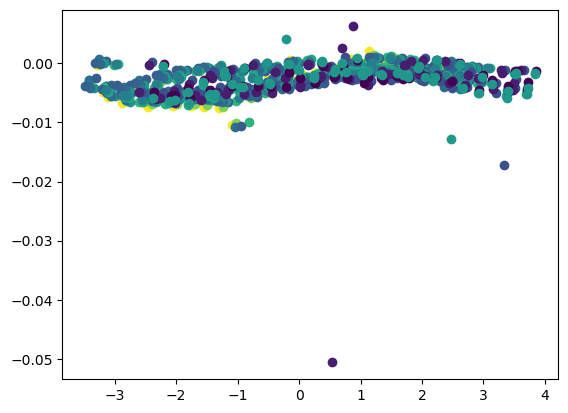

In [27]:
meanWS = ads.WS.mean(dim='time')
normWS = (meanWS - meanWS.min())/(meanWS.max() - meanWS.min())
c = plt.cm.viridis(normWS)

for ii in range(19):
    plt.scatter(delta_theta.isel(new=ii), tt_err_n.mean(dim='time').isel(new=ii), color=c[ii,:])

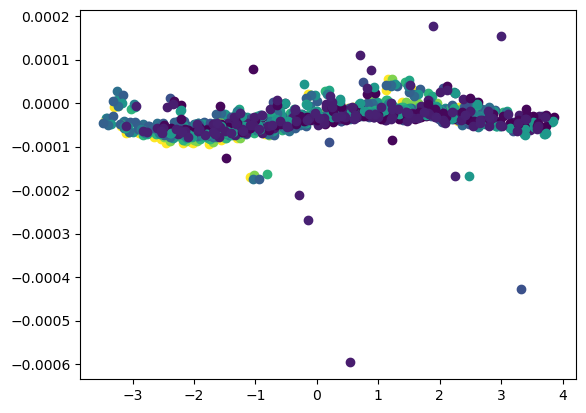

In [28]:
meanWS = ads.WS.mean(dim='time')
normWS = (meanWS - meanWS.min())/(meanWS.max() - meanWS.min())
c = plt.cm.viridis(normWS)

for ii in range(19):
    plt.scatter(delta_theta.isel(new=ii), tt_err_n.mean(dim='time').isel(new=ii)/Li.values, color=c[ii,:])

$ \sin (2\theta) = 2 \sin \theta \cos \theta = (\sin \theta +\cos \theta)^2 - 1 = \frac{2 \tan \theta} {1 + \tan^2 \theta}$

$\cos (2\theta) = \cos^2 \theta - \sin^2 \theta = 2 \cos^2 \theta - 1 = 1 - 2 \sin^2 \theta = \frac{1 - \tan^2 \theta} {1 + \tan^2 \theta} $

In [17]:
from scipy.optimize import curve_fit

def cos2x(x, amp, freq, phase, offset):
    return amp * np.cos(2 * freq * x + phase) + offset

xdata = delta_theta.values.flatten()
ydata = (tt_est_error.mean(dim='time').T/Li.values[:, None]/meanWS**2).values.flatten()
    
init = [1.35*10**-8, 1, 0, 10**-8]
params, _ = curve_fit(cos2x,  xdata, ydata, init)

x = np.linspace(-np.pi, np.pi, 100)
y = cos2x(x, *params)

In [18]:
params

array([ 1.15320562e-08,  1.00615552e+00, -3.13642119e-03,  1.28828107e-08])

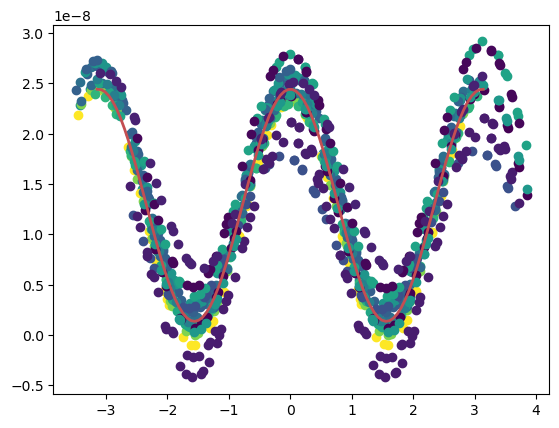

In [19]:
for ii in range(19):
    plt.scatter(delta_theta.isel(new=ii), tt_est_error.mean(dim='time').isel(new=ii)/Li.values/meanWS.isel(new=ii)**2, color=c[ii,:])
plt.plot(x,y, c='C2', lw=2)

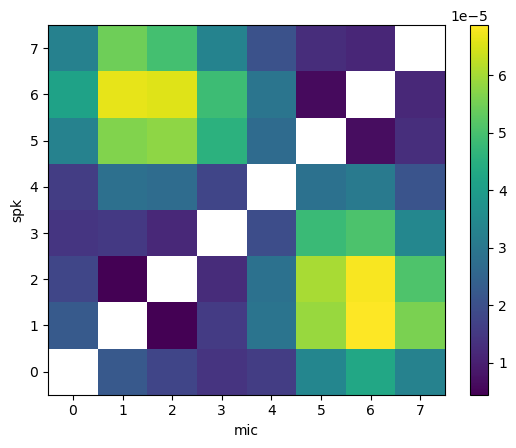

In [20]:
tt_est_error.mean(dim=['time','new']).unstack().plot()

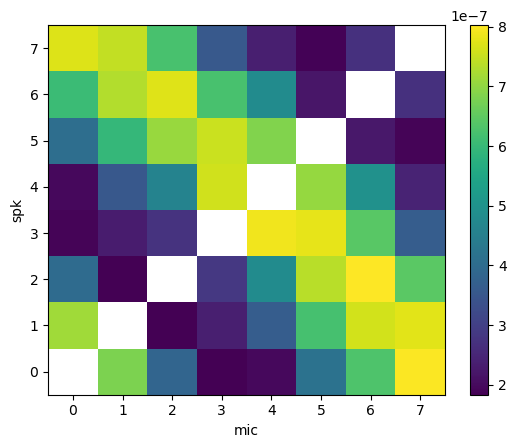

In [146]:
(tt_est_error.mean(dim=['time','new'])/Li.values).unstack().plot()

In [22]:
eps = tt_est_n.unstack() - tt_meas.unstack()
eps = eps.stack(pathID=['spk','mic']).dropna(dim='pathID', how='all')

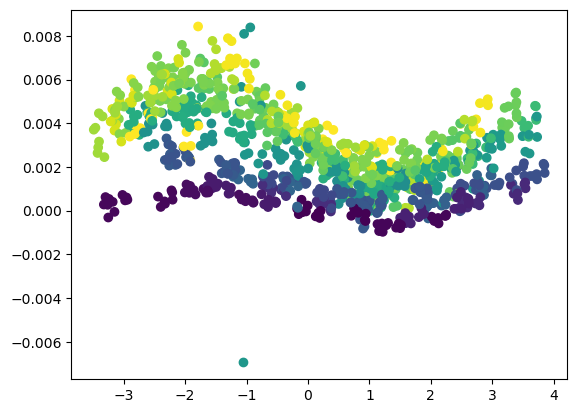

In [23]:
for ii in range(19):
    plt.scatter(delta_theta.isel(new=ii), eps.mean(dim='time').isel(new=ii), c=Li)

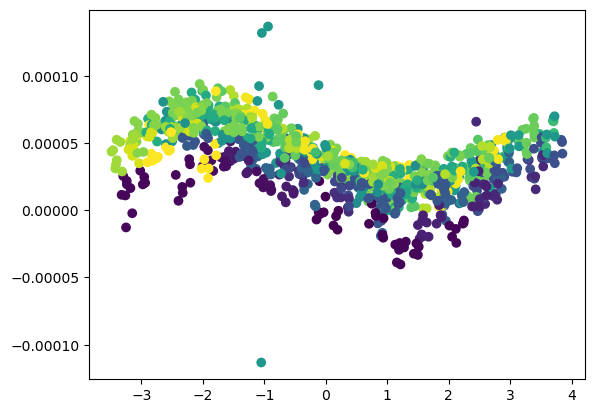

In [24]:
for ii in range(19):
    plt.scatter(delta_theta.isel(new=ii), eps.mean(dim='time').isel(new=ii)/Li.values, c=Li)

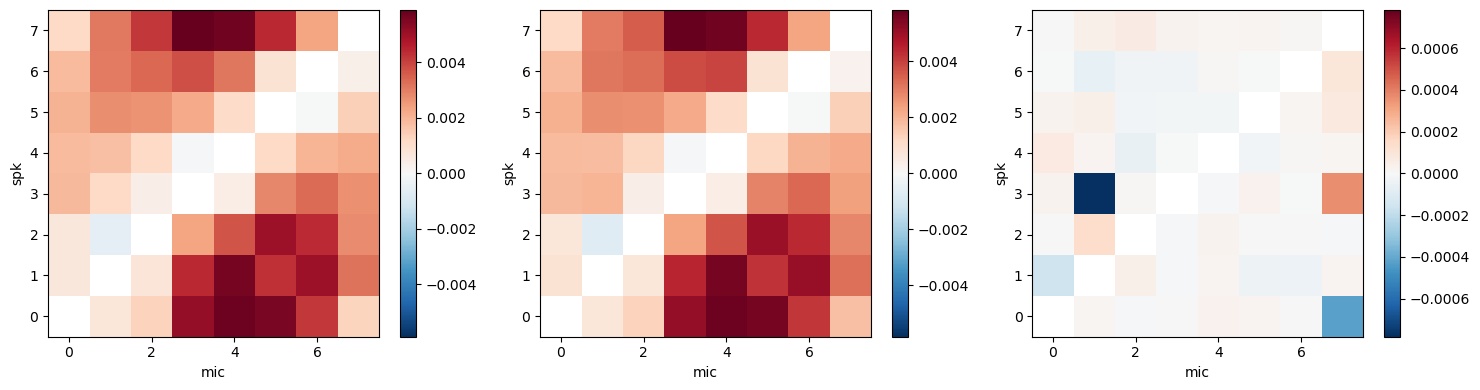

In [27]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
eps.unstack().mean(dim=['new','time']).plot(ax=ax[0])
(-tt_err_o).mean(dim=['new','time']).unstack().plot(ax=ax[1])
(eps+tt_err_o).mean(dim=['time','new']).unstack().plot(ax=ax[2])
fig.tight_layout()

Text(0, 0.5, 'tt error, new method')

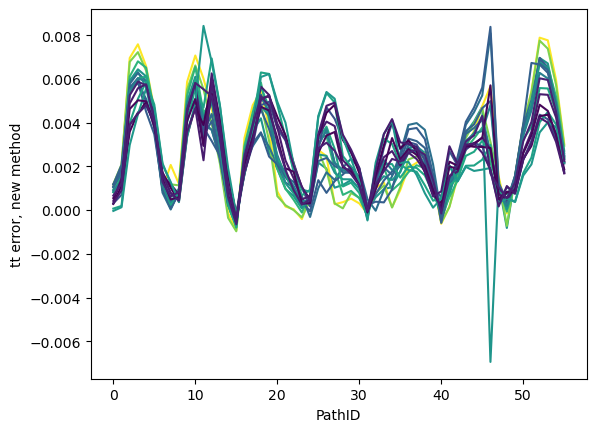

In [28]:
fig, ax = plt.subplots()
ax.set_prop_cycle(color=c)
ax.plot(eps.mean(dim='time').T,)
plt.xlabel('PathID')
plt.ylabel('tt error, new method')

In [49]:
from scipy.optimize import curve_fit

def sinx(x, amp, freq, phase, offset):
    return amp * np.sin(freq * x + phase) + offset

xdata = delta_theta.values.flatten()
ydata = (eps.fillna(0).mean(dim='time').T/Li.values[:, None]).values.flatten()
    
init = [-1e-6, 1, 0, 1e-6]
params, _ = curve_fit(sinx,  xdata, ydata, init)

x = np.linspace(-np.pi, np.pi, 100)
y = sinx(x, *params)

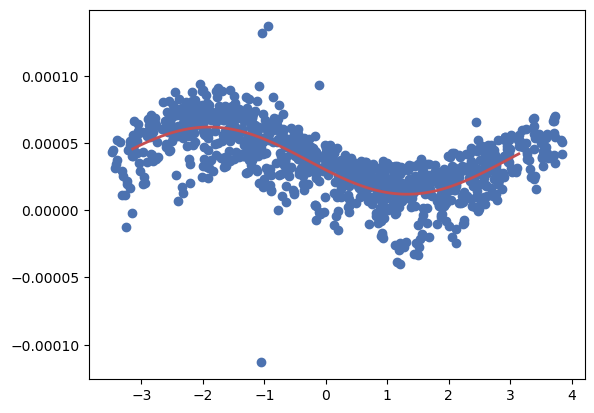

In [51]:
plt.scatter(xdata, ydata)
plt.plot(x, y, c='C2', lw=2)

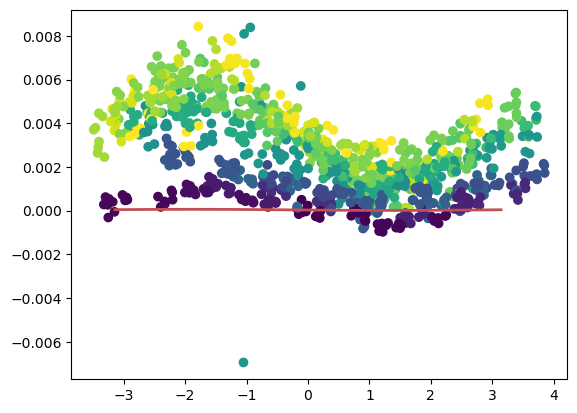

In [161]:
for ii in range(19):
    plt.scatter(delta_theta.isel(new=ii), eps.mean(dim='time').isel(new=ii), c=Li)
plt.plot(x, y, c='C2', lw=2)

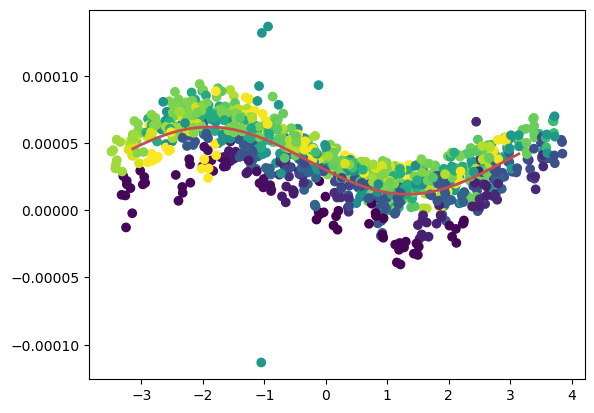

In [53]:
for ii in range(19):
    plt.scatter(delta_theta.isel(new=ii), eps.mean(dim='time').isel(new=ii)/Li.values, c=Li)
plt.plot(x, y, c='C2', lw=2)

In [69]:
dtheta = atarray.ds.pathOrientation - ads.uDir.resample(time='0.5S').mean()

In [199]:
params

array([-2.49834242e-05,  9.75330106e-01,  6.56362329e+00,  3.69116813e-05])

In [205]:
params[2]-2*np.pi

0.2804379779451205

In [200]:
3.69116813e-05/2.85

1.2951467122807017e-05

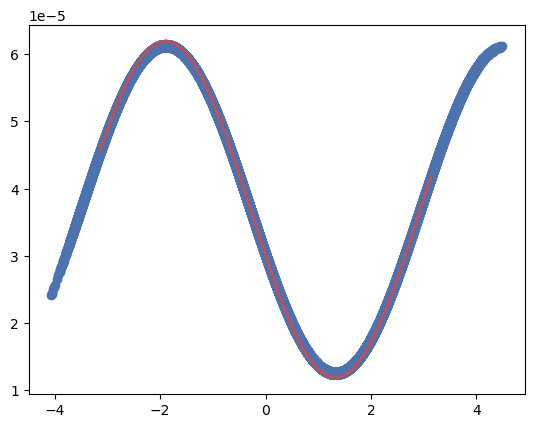

In [213]:
ytest = -2.85 * Li * np.sin(0.975*dtheta + params[2])/ads.c**2  + Li*params[3]

plt.scatter(dtheta, ytest/Li)
plt.plot(x, y, c='C2', lw=2)

ValueError: x and y must have same first dimension, but have shapes (100,) and (8, 8, 19, 120)

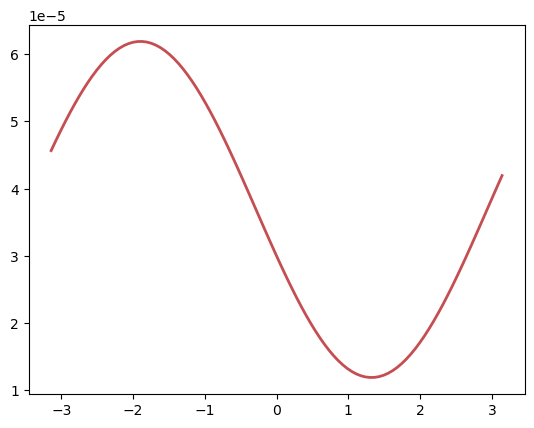

In [150]:

plt.plot(x, y, c='C2', lw=2)
plt.plot(x, ytest, c='C0', lw=2)

In [93]:
C = eps.unstack()/(Li.unstack() * np.sin(dtheta.unstack()))

In [94]:
C = C.stack(pathID=['spk','mic']).dropna(dim='pathID', how='all')

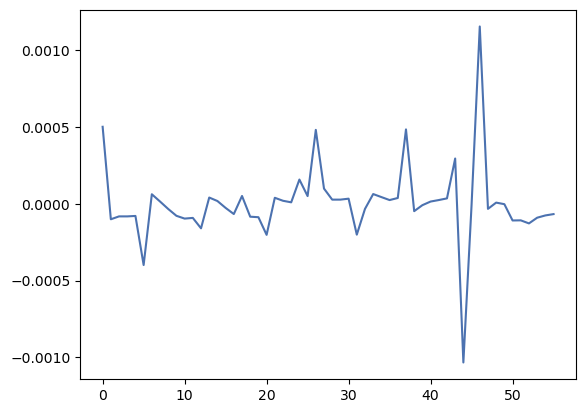

In [95]:
plt.plot(C.mean(dim=['new','time']) )

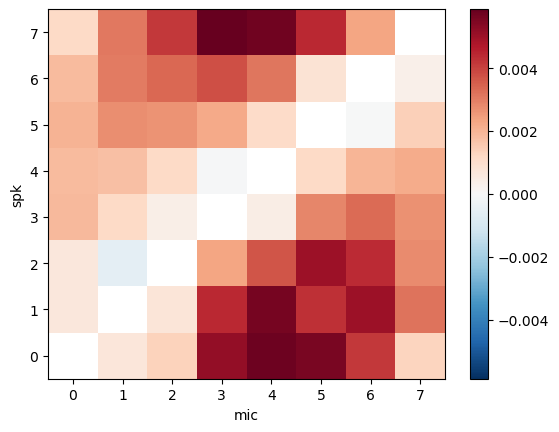

In [108]:
eps.unstack().mean(dim=['new','time']).plot()

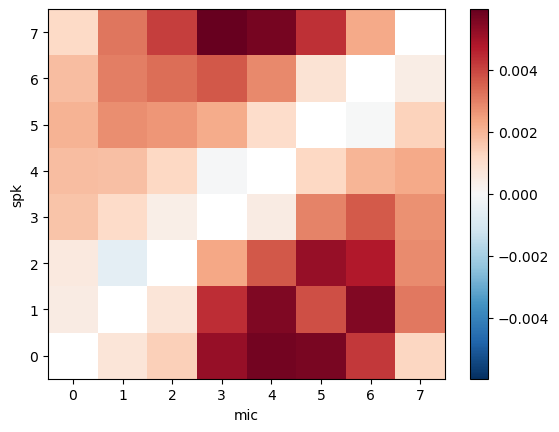

In [109]:
eps.unstack().median(dim=['new','time']).plot()

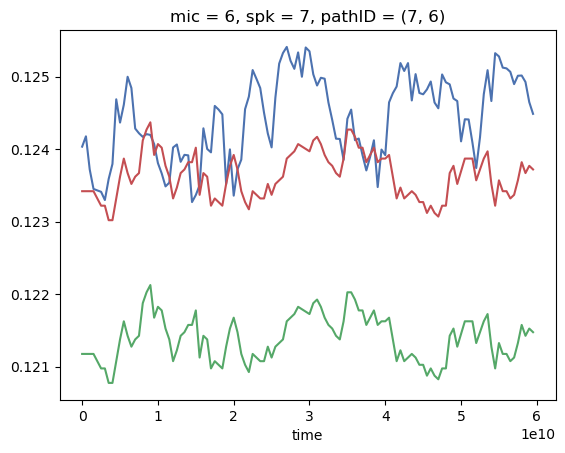

In [110]:
# pid=np.random.randint(56)
tt_est_n.isel(new=1, pathID=pid).plot()
tt_meas.isel(new=1, pathID=pid).plot()
(tt_meas.isel(new=1, pathID=pid)+eps.median(dim=['new','time']).isel(pathID=pid)).plot()

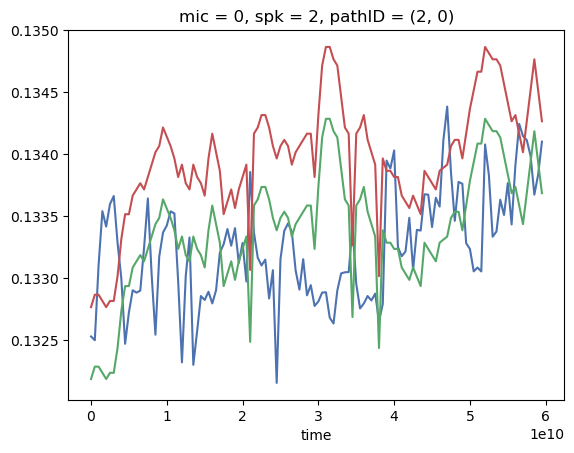

In [120]:
pid=np.random.randint(56)
tt_est_n.isel(new=1, pathID=pid).plot()
tt_meas.isel(new=1, pathID=pid).plot()
(tt_meas.isel(new=1, pathID=pid)+eps.median(dim=['new','time']).isel(pathID=pid)).plot()

In [129]:
tmp = xr.DataArray(data=tt_meas.transpose('new','pathID','time').values, coords=tt_est_n.coords)

In [130]:
tt_meas_c = tmp+eps.median(dim=['new','time'])

In [144]:
eps.median(dim=['new','time']).unstack().fillna(0).values

array([[ 0.00000000e+00,  7.57590151e-04,  1.40114756e-03,
         5.20779164e-03,  5.73354371e-03,  5.65147077e-03,
         4.18932544e-03,  1.27259520e-03],
       [ 4.81925561e-04,  0.00000000e+00,  7.46218178e-04,
         4.41304382e-03,  5.57150249e-03,  3.85902009e-03,
         5.51332015e-03,  3.16087086e-03],
       [ 5.80056413e-04, -5.70913978e-04,  0.00000000e+00,
         2.29060504e-03,  3.69431913e-03,  5.19264766e-03,
         4.76400412e-03,  2.79324061e-03],
       [ 1.69559956e-03,  1.12093610e-03,  3.85725791e-04,
         0.00000000e+00,  4.84465200e-04,  2.95009333e-03,
         3.63160981e-03,  2.71129423e-03],
       [ 1.85975544e-03,  1.78610404e-03,  1.22458551e-03,
        -8.25603489e-05,  0.00000000e+00,  1.21194404e-03,
         2.00858796e-03,  2.27842764e-03],
       [ 2.04942295e-03,  2.78054629e-03,  2.62919890e-03,
         2.21538884e-03,  1.11538812e-03,  0.00000000e+00,
        -3.77537610e-05,  1.38661448e-03],
       [ 1.84077184e-03,  3.069350